**Chapter 7, in-chapter problems**


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.interpolate import griddata

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(vec):
    return vec - np.mean(vec) / np.std(vec)

<IPython.core.display.Javascript object>

# Log-score and LPPD

It's unclear to me how this can be used to say whether a model is better or not. One way to think of it is that this R^2 for the training set. The book uses model m_7.1 as the example.

In [5]:
# code modified from the repo


df_brains = pd.DataFrame(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

df_brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


<IPython.core.display.Javascript object>

Text(0, 0.5, 'brain volume (cc)')

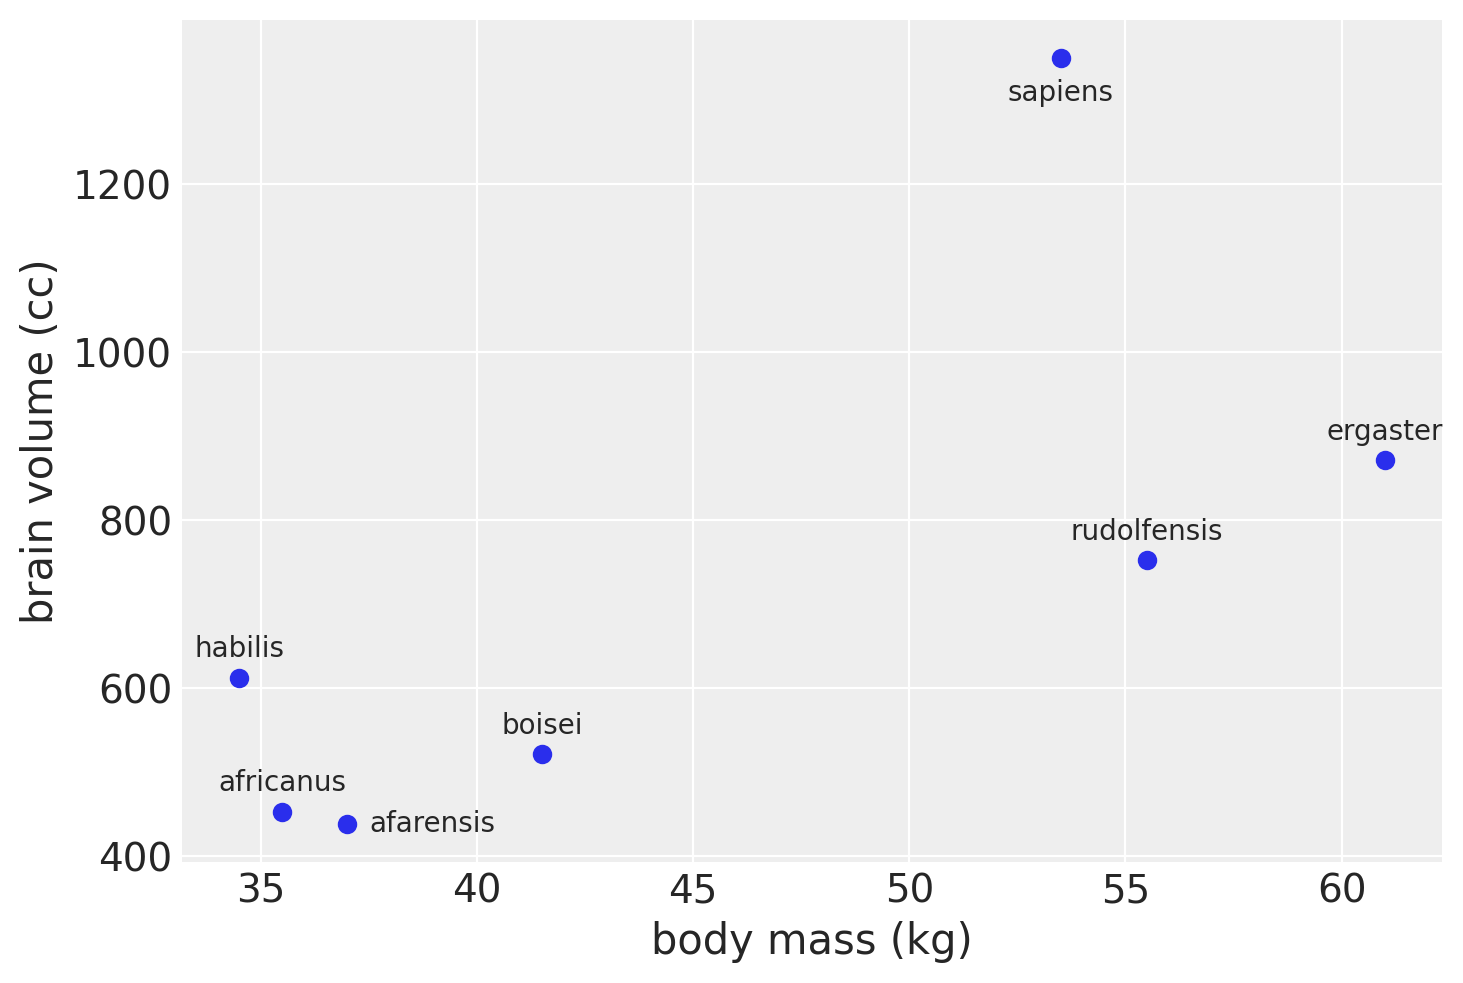

<IPython.core.display.Javascript object>

In [9]:
# Figure 7.2, modified from repo

f, ax1 = plt.subplots()

ax1.scatter(df_brains["mass"], df_brains["brain"])

# point labels
for i, r in df_brains.iterrows():
    if r.species == "afarensis":
        ax1.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        ax1.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        ax1.text(r.mass, r.brain + 25, r.species, ha="center")

ax1.set_xlabel("body mass (kg)")
ax1.set_ylabel("brain volume (cc)")

In [14]:
df_brains.head()

,species,brain,mass,brain_std,mass_std
0,afarensis,438,37.0,0.324444,32.49325
1,africanus,452,35.5,0.334815,30.99325
2,habilis,612,34.5,0.453333,29.99325
3,boisei,521,41.5,0.385926,36.99325
4,rudolfensis,752,55.5,0.557037,50.99325


<IPython.core.display.Javascript object>

In [13]:
# Standardize variables (min-max scale)
df_brains["brain_std"] = (
    df_brains["brain"] / df_brains["brain"].max()
)  # min-max scaling (min at 0)
df_brains["mass_std"] = standardize(df_brains["mass"])  # standardized

<IPython.core.display.Javascript object>

Create the model. Here are the variables.

$b_i$ ~ $\text{Normal}(\mu_i, \sigma)$
<br>
$\mu_i$ = $\alpha + \beta m_i$
<br>
$\alpha$ ~ $\text{Normal}(0.5, 1)$
<br>
$\beta$ ~ $\text{Normal}(0, 10)$
<br>
$\sigma$ ~ $\text{Log-Normal}(0, 1)$

In [17]:
with pm.Model() as m7_1:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=10)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = a + b * df_brains["mass_std"]
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    sample = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.678061473479929, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [23]:
az.summary(sample)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.022,0.440,-0.686,0.655,0.019,0.014,520.0,520.0,509.0,785.0,1.02
b,0.014,0.011,-0.002,0.030,0.000,0.000,562.0,562.0,544.0,798.0,1.01
log_sigma,-1.393,0.368,-2.022,-0.867,0.015,0.011,589.0,538.0,539.0,339.0,1.00


<IPython.core.display.Javascript object>

In [22]:
pm.find_MAP(model=m7_1)

{'a': array(-0.05379328),
 'b': array(0.01427277),
 'log_sigma': array(-1.70451573)}

<IPython.core.display.Javascript object>

In [ ]:
n_samples = 3000

intercept, slope = stats.multivariate_normal(m_7_1.params, m_7_1.cov_params()).rvs(n_samples).T


# Appendix: Environment and system parameters

In [12]:
%watermark -n -u -v -iv -w

Last updated: Thu Feb 18 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.1
matplotlib: 3.3.4
arviz     : 0.11.1
pandas    : 1.2.1
seaborn   : 0.11.1
json      : 2.0.9
pymc3     : 3.11.0
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [13]:
# Custom scripts to show packages and versions in this notebook
def imports():
    import types

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__


imported_packages = list(imports())

from active_pkg import show_pkg_vers_in_nb

show_pkg_vers_in_nb(imported_packages)

# Name                    Version                   Build  Channel
arviz                     0.11.1                   pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.20.1                   pypi_0    pypi
pandas                    1.2.1                    pypi_0    pypi
pymc3                     3.11.0                   pypi_0    pypi
scipy                     1.6.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi


<IPython.core.display.Javascript object>